In [6]:
######################################################
#
# ReaSCAN: on the mission for AGI with language.
#
# Author: Zhengxuan Wu (wuzhengx@stanford.edu)
#
# Descriptions:
# This script is used as initial plannings for the 
# ReaSCAN engine. It illustrate how to integrate different
# parts together, such as Mini-Grid gym etc..
#
# Notes:
# 1. We will leverage gSCAN core engines but with extensive 
# modifications for ReaSCAN. This ensures fairness of 
# comparisions.
######################################################

In [7]:
from collections import namedtuple, OrderedDict
import itertools
import os
import numpy as np
from typing import Tuple
from typing import List
from typing import Dict
import random
from itertools import product
import copy
import re
import random

from utils import one_hot
from utils import generate_possible_object_names
from utils import numpy_array_to_image

from vocabulary import *
from object_vocabulary import *
from world import *
from grammer import *
from simulator import *

### Vocabulary Module

In [8]:
# test out the vocabulary
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["quickly", "slowly", "while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as",
                    "inside of"]
vocabulary = Vocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)

In [9]:
# test out the object vocab
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)
# object_vocabulary.generate_objects()

### Situtation Module

In [10]:
# test out situation repr
TEST_SITUATION_1 = Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
                             target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                            position=Position(row=10, column=4),
                                                            vector=np.array([1, 0, 1])),
                             placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                              position=Position(row=10, column=4),
                                                              vector=np.array([1, 0, 1])),
                                             PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                                              position=Position(row=3, column=12),
                                                              vector=np.array([0, 1, 0]))], carrying=None)
# TEST_SITUATION_1.to_representation()

In [11]:
# test out our new object definition
PositionedObject(object=Object(size=4, color='green', shape='box'),
                 position=Position(row=3, column=12),
                 vector=np.array([0, 1, 0]), overflow=True, overlap=True)

PositionedObject(object=Object(size=4, color='green', shape='box'), position=Position(column=12, row=3), vector=array([0, 1, 0]), overflow=True, overlap=True)

### World Module with Mini-Gym

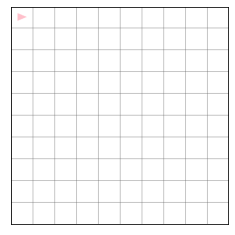

In [12]:
# test out the world
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
os.environ['QT_QPA_PLATFORM']='offscreen'
world = World(grid_size=10, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")
world_rgb = world.render_simple()

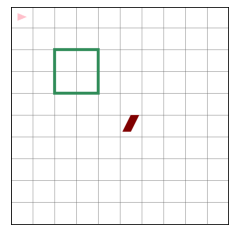

In [13]:
# try to place an object on to the map
world.clear_situation()
# world.place_object(Object(size=4, color="green", shape="box"), position=Position(row=3, column=3))
world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
world.place_object(Object(size=3, color="red", shape="cylinder"), position=Position(row=5, column=5))
_ = world.render_simple()

### ReaSCAN Grammer Module

In [14]:
grammer = Grammer(vocabulary)

In [15]:
grammer._sample_grammer_pattern_reascan_train()

['$OBJ_0 ^ $OBJ_1', '$OBJ_0 ^ $OBJ_1 & $OBJ_2', '$OBJ_0 ^ $OBJ_1 ^ $OBJ_2']

In [16]:
grammer.build_dependency_graph('$OBJ_0 ^ $OBJ_1 & $OBJ_2 ^ $OBJ_3 & $OBJ_4')

OrderedDict([('$OBJ_0', ['$OBJ_1', '$OBJ_2']),
             ('$OBJ_2', ['$OBJ_3', '$OBJ_4'])])

In [17]:
grammer.sample_object_relation_grammer(
    '$OBJ_0', 
    grammer.build_dependency_graph('$OBJ_0 ^ $OBJ_1 & $OBJ_2'))[:5]

[({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_COLUMN')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$IS_INSIDE')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_SIZE')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_COLOR')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_COLUMN'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_ROW')]))]

In [19]:
obj_pattern_map = {'$OBJ_0': '$ABS_SHAPE', '$OBJ_1': '$SIZE $SHAPE', '$OBJ_2': '$SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_ROW', ('$OBJ_0', '$OBJ_2'): '$SAME_COLUMN'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'
grammer.grounding_grammer_with_vocabulary(grammer_pattern, obj_pattern_map, rel_map)

[{'$OBJ_0': 'object', '$OBJ_1': 'big circle', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big circle', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big circle', '$OBJ_2': 'square'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big cylinder', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big cylinder', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big cylinder', '$OBJ_2': 'square'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big square', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big square', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'object', '$OBJ_1': 'big square', '$OBJ_2': 'square'},
 {'$OBJ_0': 'object', '$OBJ_1': 'small circle', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'object', '$OBJ_1': 'small circle', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'object', '$OBJ_1': 'small circle', '$OBJ_2': 'square'},
 {'$OBJ_0': 'object', '$OBJ_1': 'small cylinder', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'object', '$OBJ_1': 'small cylinder', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'object', '$OBJ_1': 

### ReaSCAN Simulator

In [ ]:
# Valid (covers uniqueness as well)
# Necessary (all relations in the command are needed)
# Distracting

In [17]:
from collections import namedtuple, OrderedDict
import itertools
import os
import numpy as np
from typing import Tuple
from typing import List
from typing import Dict
import random
from itertools import product
import copy
import re
import random

from utils import one_hot
from utils import generate_possible_object_names
from utils import numpy_array_to_image

from vocabulary import *
from object_vocabulary import *
from world import *
from grammer import *

class Simulator(object):
    """
    This convert generated grammers into a world/situation.
    
    Sample Situation:
    Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
              target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                             position=Position(row=10, column=4),
                                             vector=np.array([1, 0, 1])),
              placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                               position=Position(row=10, column=4),
                                               vector=np.array([1, 0, 1])),
                              PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                               position=Position(row=3, column=12),
                                               vector=np.array([0, 1, 0]))], carrying=None)
                                               
    Sample Placement in the World:
    world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
    
    """
    def __init__(self, object_vocabulary, vocabulary, grid_size=15, 
                 n_distractor_min=3,
                 n_distractor_max=5,
                 save_directory="./tmp/"):
        self.object_vocabulary = object_vocabulary
        self.vocabulary = vocabulary
        self.grid_size = grid_size
        self.n_distractor_min = n_distractor_min
        self.n_distractor_max = n_distractor_max

        self._world = World(grid_size=grid_size, colors=vocabulary.get_semantic_colors(),
                            object_vocabulary=object_vocabulary,
                            shapes=vocabulary.get_semantic_shapes(),
                            save_directory=save_directory)
        self._world.clear_situation()
    
    def sample_object_spec(self, obj_grammer, obj_pattern, obj_str, rel_map, 
                           is_root, obj_placed_map):
        obj_pattern = obj_pattern.split(" ")
        obj_str = obj_str.split(" ")
        color = None
        size = None
        shape = None
        if len(obj_str) == 3:
            size = self.object_vocabulary.sample_size_with_prior(prior=obj_str[0])
            color = obj_str[1]
            shape = obj_str[2]
        elif len(obj_str) == 2:
            if "$COLOR" in obj_pattern: # color + shape.
                size = self.object_vocabulary.sample_size()
                color = obj_str[0]
                shape = obj_str[1]
            elif "$SIZE" in obj_pattern: # size + shape.
                size = self.object_vocabulary.sample_size_with_prior(prior=obj_str[0])
                color = self.object_vocabulary.sample_color()
                shape = obj_str[1]
        elif len(obj_str) == 1:
            # it must be the object
            size = self.object_vocabulary.sample_size()
            color = self.object_vocabulary.sample_color()
            shape = obj_str[0]
        # Final handling for the shape.
        if shape == "object":
            shape = self.object_vocabulary.sample_shape()
            
        # Override size, color and shape based on relations.
        if not is_root:
            # Go through the rel.
            for pair, rel in rel_map.items():
                if obj_grammer == pair[-1]:
                    if pair[0] in obj_placed_map.keys():
                        # if this obj is acting as a child node
                        # then have to complain with parent node
                        if rel == "$SAME_SHAPE":
                            shape = obj_placed_map[pair[0]].shape
                        elif rel == "$SAME_COLOR":
                            color = obj_placed_map[pair[0]].color
                        elif rel == "$SAME_SIZE":
                            size = obj_placed_map[pair[0]].size
                        elif rel == "$IS_INSIDE":
                            # I think isinside is ok
                            # we can just play around with
                            # positions.
                            pass
        return Object(color=color,size=size,shape=shape)
                    
    def sample_object_position(self, sampled_obj, root, obj_grammer, rel_map, obj_placed_map, 
                               obj_position_map, retry_max=10):
        # If it is the first node, we directly return.
        if obj_grammer == root:
            sampled_pos = self._world.sample_position()
            return sampled_pos
                
        for _ in range(retry_max):
            obj_random_pos = self._world.sample_position()
            row = obj_random_pos.row
            col = obj_random_pos.column
            for pair, rel in rel_map.items():
                if obj_grammer == pair[-1]:
                    if pair[0] in obj_placed_map.keys():
                        # if this obj is acting as a child node
                        # then have to complain with parent node
                        if rel == "$SAME_ROW":
                            row = obj_position_map[pair[0]].row
                        elif rel == "$SAME_COLUMN":
                            col = obj_position_map[pair[0]].column
                        elif rel == "$IS_INSIDE":
                            # we need to make sure enclosure
                            size = sampled_obj.size
                            row_higher = min(obj_position_map[pair[0]].row, self.grid_size-size)
                            col_higher = min(obj_position_map[pair[0]].column, self.grid_size-size)
                            row_lower = max(obj_position_map[pair[0]].row-(size-1), 0)
                            col_lower = max(obj_position_map[pair[0]].column-(size-1), 0)
                            random_positions = []
                            for i in range(row_lower, row_higher+1):
                                for j in range(col_lower, col_higher+1):
                                    random_positions.append((i,j))
                            random.shuffle(random_positions)
                            for position in random_positions:
                                # consider the size and boundary as well
                                row = position[0]
                                col = position[1]
                                proposed_position=Position(row=row, column=col)
                                if not self._world.position_taken(proposed_position):
                                    break

            proposed_position=Position(row=row, column=col)
            if sampled_obj.shape != "box":
                if not self._world.position_taken(proposed_position):
                    return proposed_position
            else:
                overlap_box = False
                for obj_str, obj in obj_placed_map.items():
                    if obj.shape == "box":
                        if obj_position_map[obj_str].row == row and \
                            obj_position_map[obj_str].column == col:
                            overlap_box = True
                            break
                if not overlap_box:
                    return proposed_position
        return -1 # Fail to propose a valid position.
    
    def sample_random_object_spec(self, size_exclude=None, 
                                  color_exclude=None, shape_exclude=None):
        d_size = self.object_vocabulary.sample_size(_exclude=size_exclude)
        d_color = self.object_vocabulary.sample_color(_exclude=color_exclude)
        d_shape = self.object_vocabulary.sample_shape(_exclude=shape_exclude)
        return Object(color=d_color,size=d_size,shape=d_shape)
    
    def place_distractor_from_dict(self, distractors_dict, obj_placed_map, obj_position_map, debug=False):
        if debug:
            import pprint
            pp = pprint.PrettyPrinter(indent=4)
            pp.pprint(distractors_dict)
        distractor_root = f"$OBJ_{len(obj_placed_map)}"
        success = True
        distractors_obj_map = distractors_dict["obj_map"]
        distractors_rel_map = distractors_dict["rel_map"]
        distractors_obj_pattern_map = distractors_dict["obj_pattern_map"]
        for dis_grammer, dis_str in distractors_obj_map.items():
            # 1. Sample object.
            sampled_dis = self.sample_object_spec(
                dis_grammer,
                distractors_obj_pattern_map[dis_grammer], 
                dis_str, distractors_rel_map, 
                is_root=dis_grammer==distractor_root, 
                obj_placed_map=obj_placed_map
            )

            # 2. Place on the world map.
            sampled_pos = self.sample_object_position(
                sampled_dis, distractor_root, 
                dis_grammer, distractors_rel_map, 
                obj_placed_map, obj_position_map
            )

            if sampled_dis == -1 or sampled_pos == -1:
                return False

            self._world.place_object(
                sampled_dis, 
                position=sampled_pos, target=False # Distractor is never the target!
            )
            obj_placed_map[dis_grammer] = sampled_dis
            obj_position_map[dis_grammer] = sampled_pos
        return True
    
    def sample_situations_from_grounded_grammer(self, grammer_pattern, 
                                                obj_pattern_map, rel_map, obj_map, root="$OBJ_0", 
                                                is_plot=False, 
                                                include_random_distractor=False, 
                                                include_relation_distractor=False, 
                                                include_size_distractor=False, 
                                                include_isomorphism_distractor=False, 
                                                debug=False):
        # Clear current world.
        self._world.clear_situation()
        
        # Start placing objects with specs.
        obj_placed_map = OrderedDict({})
        obj_position_map = OrderedDict({})
        referred_obj = root
        for obj_grammer, obj_str in obj_map.items():
            # 1. Sample object.
            sampled_obj = self.sample_object_spec(
                obj_grammer,
                obj_pattern_map[obj_grammer], obj_str, rel_map, 
                is_root=obj_grammer==root, 
                obj_placed_map=obj_placed_map
            )
            
            # 2. Place on the world map.
            sampled_pos = self.sample_object_position(
                sampled_obj, root, obj_grammer, rel_map, 
                obj_placed_map, obj_position_map
            )
            
            if sampled_obj == -1 or sampled_pos == -1:
                return -1 # Fail to sample.

            self._world.place_object(
                sampled_obj, 
                position=sampled_pos, target=obj_grammer==root
            )
            obj_placed_map[obj_grammer] = sampled_obj
            obj_position_map[obj_grammer] = sampled_pos
        
        """
        Calling in this way to create distractors:

        simulator.sample_distractor_grammer_by_relation(
            grammer_pattern, 
            obj_pattern_map, 
            rel_map, 
            obj_map, 
            sampled_world
        )
        """
        temp_sampled_world = {
            "obj_map" : obj_placed_map,
            "pos_map" : obj_position_map,
            "referred_obj" : referred_obj,
            "situation" : copy.deepcopy(self._world.get_current_situation())
        }
        
        # Three types of distractor sampling for different purposes:
        # sample_distractor_grammer_by_relation()
        # - We will edit one leaf node, so that it makes sure
        #   the command is necessary!
        # sample_distractor_grammer_by_size()
        # - Size relatives need to be meaningful. We will add relational
        #   objects to make sure.
        # sample_distractor_grammer_by_isomorphism()
        # - This is to ensure syntax learning.
        
        """
        Example of the return data structure:

        [{'grammer_pattern': '$OBJ_0 ^ $OBJ_1 & $OBJ_2',
          'obj_pattern_map': {'$OBJ_0': '$ABS_SHAPE',
           '$OBJ_1': 'small red circle',
           '$OBJ_2': 'square'},
          'rel_map': {('$OBJ_0', '$OBJ_1'): '$SAME_ROW',
           ('$OBJ_0', '$OBJ_2'): '$SAME_COLOR'},
          'obj_map': {'$OBJ_0': 'object',
           '$OBJ_1': '$SIZE $COLOR $SHAPE',
           '$OBJ_2': '$SHAPE'},
          'size_map': {}}]
        """
        distractor_switch_map = OrderedDict({
            "relation" : False,
            "size" : False,
            "isomorphism" : False, 
            "random" : False
        })

        # Include the relation distractor.
        if include_relation_distractor:
            relation_distractors_dicts = self.sample_distractor_grammer_by_relation(
                grammer_pattern, 
                obj_pattern_map, 
                rel_map, 
                obj_map, 
                temp_sampled_world,
                obj_base_count=len(obj_placed_map)
            )
            succeed = self.place_distractor_from_dict(
                relation_distractors_dicts[0], 
                obj_placed_map, 
                obj_position_map,
                debug=debug
            )
            if succeed:
                distractor_switch_map["relation"] = True
        
        # Include the size distractor.
        if include_size_distractor:
            size_distractors_dicts = self.sample_distractor_grammer_by_size(
                grammer_pattern, 
                obj_pattern_map, 
                rel_map, 
                obj_map, 
                temp_sampled_world,
                obj_base_count=len(obj_placed_map)
            )
            if len(size_distractors_dicts) == 0:
                pass # Size distractor is not applicable 
            else:
                succeed = self.place_distractor_from_dict(
                    size_distractors_dicts[0], 
                    obj_placed_map, 
                    obj_position_map,
                    debug=debug
                )
                if succeed:
                    distractor_switch_map["size"] = True

        # Include ths isomorphism-based distractor.
        if include_isomorphism_distractor:
            isomorphism_distractors_dicts = self.sample_distractor_grammer_by_isomorphism(
                grammer_pattern, 
                obj_pattern_map, 
                rel_map, 
                obj_map, 
                temp_sampled_world,
                obj_base_count=len(obj_map)
            )
            succeed = self.place_distractor_from_dict(
                isomorphism_distractors_dicts[0], 
                obj_placed_map, 
                obj_position_map,
                debug=debug
            )
            if succeed:
                distractor_switch_map["isomorphism"] = True

        # Place random distractors. These are gSCAN like distractors
        # which are often not very meaningful for testing agents language
        # knowledge. We recommand always turn this off and use other
        # relation-based distractor sampling strategies.
        if include_random_distractor:
            n_distractor = random.randint(1, 3)
            core_obj_count = len(obj_placed_map)
            for i in range(0, n_distractor):
                distractor_idx = core_obj_count+i
                distractor_name = f"$OBJ_{distractor_idx}"
                sampled_distractor = self.sample_random_object_spec()
                sampled_dis_pos = self._world.sample_position()
                self._world.place_object(
                    sampled_distractor, 
                    position=sampled_dis_pos, target=False
                )
                obj_placed_map[distractor_name] = sampled_distractor
                obj_position_map[distractor_name] = sampled_dis_pos
            distractor_switch_map["random"] = True

        agent_position = self._world.sample_position()
        self._world.place_agent_at(agent_position)
        if is_plot:
            _ = self._world.render_simple()
        
        return {
            "obj_map" : obj_placed_map,
            "pos_map" : obj_position_map,
            "referred_obj" : referred_obj,
            "situation" : copy.deepcopy(self._world.get_current_situation()), 
            "distractor_switch_map" : distractor_switch_map
        }
    
    def extract_size(self, obj_str):
        obj_descriptors = obj_str.split(" ")
        for descriptor in obj_descriptors:
            if descriptor in ["small", "big"]:
                return descriptor
        return ""

    def extract_color(self, obj_str):
        obj_descriptors = obj_str.split(" ")
        for descriptor in obj_descriptors:
            if descriptor in self.object_vocabulary.object_colors:
                return descriptor
        return ""
    
    def extract_shape(self, obj_str):
        obj_descriptors = obj_str.split(" ")
        for descriptor in obj_descriptors:
            if descriptor in self.object_vocabulary.object_shapes:
                return descriptor
        return ""

    def convert_object_str_to_grammer(self, obj_str):
        size_g = False
        color_g = False
        abs_shape_g = False

        obj_descriptors = obj_str.split(" ")
        for descriptor in obj_descriptors:
            if descriptor in ["small", "big"]:
                size_g = True
            elif descriptor in self.object_vocabulary.object_colors:
                color_g = True
            elif descriptor in self.object_vocabulary.object_shapes:
                pass
            elif descriptor == "object":
                abs_shape_g = True

        grammer = []
        if size_g:
            grammer.append("$SIZE")
        if color_g:
            grammer.append("$COLOR")
        if abs_shape_g:
            grammer.append("$ABS_SHAPE")
        else:
            grammer.append("$SHAPE")
        
        return " ".join(grammer)

    def snap_pattern_to_referent_map(self, distractor_grammer_pattern, base_count):
        distractor_grammer_pattern_snapped = []
        for item in distractor_grammer_pattern.split(" "):
            if item.startswith("$"):
                new_id = int(item.split("_")[1])+base_count
                distractor_grammer_pattern_snapped.append(f"$OBJ_{new_id}")
            else:
                distractor_grammer_pattern_snapped.append(item)
        return " ".join(distractor_grammer_pattern_snapped)

    def snap_object_map_to_referent_map(self, distractor_map, base_count):
        distractor_map_snapped = OrderedDict({})
        for obj_name, item in distractor_map.items():
            new_id = int(obj_name.split("_")[1])+base_count
            new_obj_name = f"$OBJ_{new_id}"
            distractor_map_snapped[new_obj_name] = item
        return distractor_map_snapped

    def snap_relation_map_to_referent_map(self, distractor_rel_map, base_count):
        distractor_rel_map_snapped = OrderedDict({})
        for edge, item in distractor_rel_map.items():
            if edge[0].startswith("$"):
                new_id_left = int(edge[0].split("_")[1])+base_count
                new_obj_name_left = f"$OBJ_{new_id_left}"
            else:
                new_obj_name_left = edge[0]
            
            if edge[1].startswith("$"):
                new_id_right = int(edge[1].split("_")[1])+base_count
                new_obj_name_right = f"$OBJ_{new_id_right}"
            else:
                new_obj_name_right = edge[1]
            distractor_rel_map_snapped[(new_obj_name_left, new_obj_name_right)] = item
        return distractor_rel_map_snapped
    
    def sample_distractor_grammer_by_relation(
        self, 
        referent_grammer_pattern, 
        referent_obj_pattern_map,
        referent_rel_map,
        referent_obj_map, 
        sampled_world,
        surgery_operations=["REL_ADJUST", "OBJ_ADJUST"],
        obj_base_count=0
    ):

        # First, let us make copies.
        distractor_grammer_pattern = copy.deepcopy(referent_grammer_pattern)
        distractor_obj_pattern_map = copy.deepcopy(referent_obj_pattern_map)
        distractor_rel_map = copy.deepcopy(referent_rel_map)
        distractor_obj_map = copy.deepcopy(referent_obj_map)

        # We may need to enforce the size of the distractor due to size descriptors!
        distractor_size_map = {}

        # To have valid distractor, the original relational map must
        # be missing some leaf edges.
        # e.g., A->B->C becomes A'->B (or object with same descriptor as B) 
        # assums arrow represents the same relational type. A' will be 
        # different than A since C is missing.

        leaf_edges = []
        for edge, relation in distractor_rel_map.items():
            is_leaf = True
            for _edge, _relation in distractor_rel_map.items():
                if edge[1] == _edge[0]:
                    is_leaf = False
                    break
            if is_leaf:
                leaf_edges.append(edge)

        # leaf_edges only contains a single pair, we continue to remove it.
        if len(leaf_edges) == 1:
            pass

        # To remove it, we can take the following actions:
        # 1. Change the relation type.
        # 2. Change the leaf node attributes.
        selected_leaf_edge = random.choice(leaf_edges)
        selected_surgery = random.choice(surgery_operations)
        if "box" in distractor_obj_map[selected_leaf_edge[1]] and \
            "$COLOR" not in distractor_obj_pattern_map[selected_leaf_edge[1]]:
            selected_surgery = "REL_ADJUST"

        if selected_surgery == "REL_ADJUST":
            if distractor_rel_map[selected_leaf_edge] == "$IS_INSIDE":
                # We also need to change the leaf object anyway.
                new_rels = ["$SAME_ROW", "$SAME_COLUMN", "$SAME_SHAPE", "$SAME_COLOR", "$SAME_SIZE"]
                new_rel = random.choice(new_rels)
                # Update fields.
                shape = self.object_vocabulary.sample_shape()
                distractor_rel_map[selected_leaf_edge] = new_rel
                distractor_obj_map[selected_leaf_edge[1]] = shape
                distractor_obj_pattern_map[selected_leaf_edge[1]] = '$SHAPE'
            else:
                new_rels = ["$SAME_ROW", "$SAME_COLUMN", "$SAME_SHAPE", "$SAME_COLOR", "$SAME_SIZE", "$IS_INSIDE"]
                new_rels = set(new_rels) - set([distractor_rel_map[selected_leaf_edge]])
                new_rel = random.choice(list(new_rels))
                if new_rel == "$IS_INSIDE":
                    shape = "box"
                    distractor_obj_map[selected_leaf_edge[1]] = shape
                    distractor_obj_pattern_map[selected_leaf_edge[1]] = '$SHAPE'
                else:
                    pass # What about we just don't update the shape?
                # Update fields.
                distractor_rel_map[selected_leaf_edge] = new_rel
        elif selected_surgery == "OBJ_ADJUST":
            original_object_name = selected_leaf_edge[1]
            original_object_str = distractor_obj_map[original_object_name]
            original_object = sampled_world['obj_map'][original_object_name]
            # Shape color, we can change, I think.
            adjustable_attributes = ["color", "shape"]
            adjust_attribute = random.choice(adjustable_attributes)
            # If the original object does not have color as attribute, sampling on color
            # is highly likely leading to non-unique referent targets.
            if "$COLOR" not in distractor_obj_pattern_map[original_object_name]:
                adjust_attribute = "shape"
            if "box" in original_object_str:
                adjust_attribute = "color"
            if adjust_attribute == "color":
                new_color = self.object_vocabulary.sample_color(_exclude=[original_object.color])
                new_object_str = new_color + " " + original_object.shape
            elif adjust_attribute == "shape":
                new_shape = self.object_vocabulary.sample_shape(_exclude=[original_object.shape])
                new_object_str = original_object.color + " " + new_shape
            new_object_grammer = "$COLOR $SHAPE"
            distractor_obj_map[original_object_name] = new_object_str
            distractor_obj_pattern_map[original_object_name] = new_object_grammer
        else:
            pass # Not implemented

        # We need to snap this distractors onto the regular relations.
        
        # We need to increment the object counters.
        return [{
                    "grammer_pattern" : self.snap_pattern_to_referent_map(
                        distractor_grammer_pattern,
                        obj_base_count
                    ),
                    "obj_pattern_map" : self.snap_object_map_to_referent_map(
                        distractor_obj_pattern_map,
                        obj_base_count
                    ),
                    "rel_map" : self.snap_relation_map_to_referent_map(
                        distractor_rel_map,
                        obj_base_count
                    ),
                    "obj_map" : self.snap_object_map_to_referent_map(
                        distractor_obj_map,
                        obj_base_count
                    ),
                    "size_map" : self.snap_object_map_to_referent_map(
                        distractor_size_map,
                        obj_base_count
                    )
                }]
    
    def sample_distractor_grammer_by_size(
        self,
        referent_grammer_pattern, 
        referent_obj_pattern_map,
        referent_rel_map,
        referent_obj_map, 
        sampled_world,
        obj_base_count=0,
    ):
        """
        Our main relation may contains size descriptors such as
        "small" or "big". For these, to make sure they are effectively
        grounded, we need to sample distractors to make sure they 
        are useful in the reasoning.
        
        Currently, we enforce it returns 1. So, across samples, the
        size descriptor needs to be relatively grounded.
        """
        grounded_distractor_grammers = []

        for obj_name, obj_grammer in referent_obj_pattern_map.items():
            if "$SIZE" in obj_grammer:
                # First, let us make copies.
                distractor_grammer_pattern = copy.deepcopy(referent_grammer_pattern)
                distractor_obj_pattern_map = copy.deepcopy(referent_obj_pattern_map)
                distractor_rel_map = copy.deepcopy(referent_rel_map)
                distractor_obj_map = copy.deepcopy(referent_obj_map)
                # We may need to enforce the size of the distractor due to size descriptors!
                distractor_size_map = {}

                original_object_str = distractor_obj_map[obj_name]
                original_object = sampled_world['obj_map'][obj_name]
                original_object_size = original_object.size
                if "small" in original_object_str:
                    distractor_size = random.randint(original_object_size+1, 4)
                elif "big" in original_object_str:
                    distractor_size = random.randint(1, original_object_size-1)
                else:
                    pass # Not Implemented
                distractor_size_map[obj_name] = distractor_size
                distractor_color = original_object.color
                distractor_shape = original_object.shape
                new_object_grammer = "$COLOR $SHAPE"
                distractor_obj_map[obj_name] = distractor_color + " " + distractor_shape
                distractor_obj_pattern_map[obj_name] = new_object_grammer

                grounded_distractor_grammers.append({
                    "grammer_pattern" : self.snap_pattern_to_referent_map(
                        distractor_grammer_pattern,
                        obj_base_count
                    ),
                    "obj_pattern_map" : self.snap_object_map_to_referent_map(
                        distractor_obj_pattern_map,
                        obj_base_count
                    ),
                    "rel_map" : self.snap_relation_map_to_referent_map(
                        distractor_rel_map,
                        obj_base_count
                    ),
                    "obj_map" : self.snap_object_map_to_referent_map(
                        distractor_obj_map,
                        obj_base_count
                    ),
                    "size_map" : self.snap_object_map_to_referent_map(
                        distractor_size_map,
                        obj_base_count
                    )
                })
        random.shuffle(grounded_distractor_grammers)
        return grounded_distractor_grammers[:1]

    def sample_distractor_grammer_by_isomorphism(
        self,
        referent_grammer_pattern, 
        referent_obj_pattern_map,
        referent_rel_map,
        referent_obj_map, 
        sampled_world,
        obj_base_count=0,
    ):
        """
        This set of distractors are for learning syntax and grammers.
        If you simply use BoW approach, it will not work because we 
        always instill confusing targets for you with isomorphism of the
        referent graph.

        For example, if the original grounded command is:
        Go to the red square that is inside of the yellow box.

        We can do a isomorphism which is
        Go to the yellow square that is inside of the red box.

        If the model is not understanding the language correctly,
        it will not able to find the referent target correctly.
        """
        # First, let us make copies.
        distractor_grammer_pattern = copy.deepcopy(referent_grammer_pattern)
        distractor_obj_pattern_map = copy.deepcopy(referent_obj_pattern_map)
        distractor_rel_map = copy.deepcopy(referent_rel_map)
        distractor_obj_map = copy.deepcopy(referent_obj_map)
        # We may need to enforce the size of the distractor due to size descriptors!
        distractor_size_map = {}

        shufflable_objects = []
        for obj_name, obj_str in distractor_obj_map.items():
            obj_descriptors = obj_str.split(" ")
            if len(obj_descriptors) > 1:
                shufflable_objects.append((obj_name, obj_str))
        if len(shufflable_objects) > 2:
            random.shuffle(shufflable_objects)
        shufflable_objects = shufflable_objects[:2]

        if len(shufflable_objects) == 1:
            return [] # We simply don't have enough objects to do this.

        # We will shuffle attributes between two objects.

        # Prepare shufflable materials.
        obj_name_left = shufflable_objects[0][0]
        obj_name_right = shufflable_objects[1][0]
        size_left = self.extract_size(shufflable_objects[0][1])
        size_right = self.extract_size(shufflable_objects[1][1])
        color_left = self.extract_color(shufflable_objects[0][1])
        color_right = self.extract_color(shufflable_objects[1][1])
        shape_left = self.extract_shape(shufflable_objects[0][1])
        shape_right = self.extract_shape(shufflable_objects[1][1])
        
        left_rebuild = []
        right_rebuild = []
        # If we shuffle size...
        if random.random() > 0.5:
            tmp = size_left
            size_left = size_right
            size_right = tmp
        if size_left != "":
            left_rebuild.append(size_left)
        if size_right != "":
            right_rebuild.append(size_right)

        # If we shuffle color...
        if random.random() > 0.5:
            tmp = color_left
            color_left = color_right
            color_right = tmp
        if color_left != "":
            left_rebuild.append(color_left)
        if color_right != "":
            right_rebuild.append(color_right)

        # If we shuffle shape...
        if random.random() > 0.5 and shape_left != "box" and shape_right != "box":
            tmp = shape_left
            shape_left = shape_right
            shape_right = tmp
        if shape_left != "":
            left_rebuild.append(shape_left)
        else:
            left_rebuild.append("object")
        if shape_right != "":
            right_rebuild.append(shape_right)
        else:
            right_rebuild.append("object")
                
        left_rebuild = " ".join(left_rebuild)
        right_rebuild = " ".join(right_rebuild)
        left_grammer_rebuild = self.convert_object_str_to_grammer(left_rebuild)
        right_grammer_rebuild = self.convert_object_str_to_grammer(right_rebuild)
        
        distractor_obj_pattern_map[obj_name_left] = left_rebuild
        distractor_obj_pattern_map[obj_name_right] = right_rebuild
        distractor_obj_map[obj_name_left] = left_grammer_rebuild
        distractor_obj_map[obj_name_right] = right_grammer_rebuild
        
        return [{
                    "grammer_pattern" : self.snap_pattern_to_referent_map(
                        distractor_grammer_pattern,
                        obj_base_count
                    ),
                    "obj_pattern_map" : self.snap_object_map_to_referent_map(
                        distractor_obj_pattern_map,
                        obj_base_count
                    ),
                    "rel_map" : self.snap_relation_map_to_referent_map(
                        distractor_rel_map,
                        obj_base_count
                    ),
                    "obj_map" : self.snap_object_map_to_referent_map(
                        distractor_obj_map,
                        obj_base_count
                    ),
                    "size_map" : self.snap_object_map_to_referent_map(
                        distractor_size_map,
                        obj_base_count
                    )
                }]
    

In [18]:
simulator = Simulator(
    object_vocabulary, vocabulary, 
    grid_size=6, 
    n_distractor_min=0,
    n_distractor_max=0
)

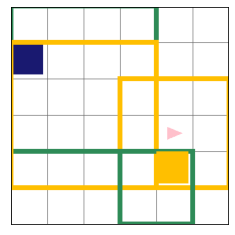

In [28]:
obj_pattern_map = {'$OBJ_0': '$ABS_SHAPE', '$OBJ_1': '$SIZE $SHAPE', '$OBJ_2': '$COLOR $SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$IS_INSIDE', ('$OBJ_0', '$OBJ_2'): '$IS_INSIDE'}
obj_map = {'$OBJ_0': 'object', '$OBJ_1': 'small box', '$OBJ_2': 'yellow box'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'

sampled_world = simulator.sample_situations_from_grounded_grammer(
    grammer_pattern, 
    obj_pattern_map, 
    rel_map, 
    obj_map,
    is_plot=True,
    include_random_distractor=False, 
    include_relation_distractor=False, 
    include_size_distractor=True, 
    include_isomorphism_distractor=False, 
    debug=False
)

In [29]:
sampled_world

{'obj_map': OrderedDict([('$OBJ_0',
               Object(size=4, color='yellow', shape='square')),
              ('$OBJ_1', Object(size=2, color='green', shape='box')),
              ('$OBJ_2', Object(size=3, color='yellow', shape='box')),
              ('$OBJ_3', Object(size=4, color='blue', shape='square')),
              ('$OBJ_4', Object(size=4, color='green', shape='box')),
              ('$OBJ_5', Object(size=4, color='yellow', shape='box'))]),
 'pos_map': OrderedDict([('$OBJ_0', Position(column=4, row=4)),
              ('$OBJ_1', Position(column=3, row=4)),
              ('$OBJ_2', Position(column=3, row=2)),
              ('$OBJ_3', Position(column=0, row=1)),
              ('$OBJ_4', Position(column=0, row=0)),
              ('$OBJ_5', Position(column=0, row=1))]),
 'referred_obj': '$OBJ_0',
 'situation': <world.Situation at 0x7ff91db43be0>,
 'distractor_switch_map': OrderedDict([('relation', False),
              ('size', True),
              ('isomorphism', False),
       

OrderedDict([(('$OBJ_0', 'yellow'), ['$COLOR']), (('$OBJ_0', 'square'), ['$SHAPE']), (('$OBJ_1', 'green'), ['$COLOR']), (('$OBJ_1', 'box'), ['$SHAPE']), (('$OBJ_1', 'small'), ['$SIZE']), (('$OBJ_2', 'yellow'), ['$COLOR']), (('$OBJ_2', 'box'), ['$SHAPE']), (('$OBJ_2', 'big'), ['$SIZE']), (('$OBJ_2', 'small'), ['$SIZE']), (('$OBJ_3', 'blue'), ['$COLOR']), (('$OBJ_3', 'square'), ['$SHAPE']), (('$OBJ_4', 'green'), ['$COLOR']), (('$OBJ_4', 'box'), ['$SHAPE']), (('$OBJ_4', 'big'), ['$SIZE']), (('$OBJ_5', 'yellow'), ['$COLOR']), (('$OBJ_5', 'box'), ['$SHAPE']), (('$OBJ_5', 'big'), ['$SIZE']), (('$OBJ_0', '$OBJ_1'), ['$SAME_ROW', '$IS_INSIDE']), (('$OBJ_0', '$OBJ_2'), ['$SAME_COLOR', '$IS_INSIDE']), (('$OBJ_0', '$OBJ_3'), ['$SAME_SIZE', '$SAME_SHAPE']), (('$OBJ_0', '$OBJ_4'), ['$SAME_SIZE']), (('$OBJ_0', '$OBJ_5'), ['$SAME_SIZE', '$SAME_COLOR']), (('$OBJ_1', '$OBJ_0'), ['$SAME_ROW']), (('$OBJ_1', '$OBJ_2'), ['$SAME_COLUMN', '$SAME_SHAPE', '$IS_INSIDE']), (('$OBJ_1', '$OBJ_4'), ['$SAME_COLOR', 

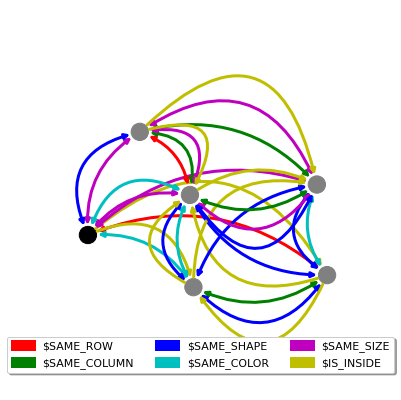

In [37]:
graph = ReaSCANGraph(
    objects=sampled_world["obj_map"], 
    vocabulary=vocabulary,
    positions=sampled_world["pos_map"], 
    referred_object=sampled_world["referred_obj"],
    debug=True
)
graph.draw()

OrderedDict([(('$OBJ_1', 'small'), ['$SIZE']), (('$OBJ_1', 'box'), ['$SHAPE']), (('$OBJ_2', 'yellow'), ['$COLOR']), (('$OBJ_2', 'box'), ['$SHAPE'])])


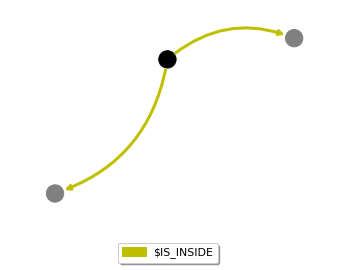

In [36]:
pattern_graph = ReaSCANGraph(
    objects=obj_map, 
    vocabulary=vocabulary,
    relations=rel_map, 
    referred_object='$OBJ_0', 
    debug=False
)
pattern_graph.draw()

In [34]:
graph.find_referred_object(
    pattern_graph, referred_object='$OBJ_0'
)

{'$OBJ_0', '$OBJ_1'}

In [1249]:
print("Command:")
command_str = grammer.repre_str_command(grammer_pattern, rel_map, obj_map)
print(f"walk to {command_str} cautiously")

Command:
walk to the object that is inside of the box and inside of the yellow box cautiously


In [35]:
import networkx as nx

class ReaSCANGraph(object):
    """
    SAME_ROW_REGEX = "$SAME_ROW"
    SAME_COL_REGEX = "$SAME_COLUMN"
    SAME_SHAPE_REGEX = "$SAME_SHAPE"
    SAME_COLOR_REGEX = "$SAME_COLOR"
    SAME_SIZE_REGEX = "$SAME_SIZE"
    IS_INSIDE_REGEX = "$IS_INSIDE"
    """

    def __init__(
        self, objects, vocabulary, 
        relations=None, positions=None, referred_object=None,
        debug=False
    ):
        self.vocabulary = vocabulary
        self.relations = OrderedDict({})
        self.G = nx.MultiDiGraph()
        self.G_full = nx.MultiDiGraph()
        if positions == None:
            # This means it is a abstract pattern, not a grounded shapeWorld graph.
            for obj_name, obj_str in objects.items():
                if referred_object != None and obj_name == referred_object:
                    self.G.add_node(obj_name, type="object", referent=True)
                    self.G_full.add_node(obj_name, type="object", referent=True)
                else:
                    self.G.add_node(obj_name, type="object", referent=False)
                    self.G_full.add_node(obj_name, type="object", referent=False)
                obj_str = obj_str.split(" ")
                if len(obj_str) == 1:
                    if obj_str[0] != "object":
                        self.relations[(obj_name, obj_str[0])] = ['$SHAPE']
                elif len(obj_str) == 2:
                    if obj_str[0] in vocabulary.get_size_adjectives():
                        self.relations[(obj_name, obj_str[0])] = ['$SIZE']
                    elif obj_str[0] in vocabulary.get_color_adjectives():
                        self.relations[(obj_name, obj_str[0])] = ['$COLOR']
                    if obj_str[1] != "object":
                        self.relations[(obj_name, obj_str[1])] = ['$SHAPE']
                elif len(obj_str) == 3:
                    if obj_str[0] in vocabulary.get_size_adjectives():
                        self.relations[(obj_name, obj_str[0])] = ['$SIZE']
                    elif obj_str[0] in vocabulary.get_color_adjectives():
                        self.relations[(obj_name, obj_str[0])] = ['$COLOR']
                    if obj_str[1] in vocabulary.get_size_adjectives():
                        self.relations[(obj_name, obj_str[0])] = ['$SIZE']
                    elif obj_str[1] in vocabulary.get_color_adjectives():
                        self.relations[(obj_name, obj_str[0])] = ['$COLOR']
                    if obj_str[2] != "object":
                        self.relations[(obj_name, obj_str[0])] = ['$SHAPE']
            for edge, relation in relations.items():
                src_node, dst_node = edge[0], edge[1]
                if (src_node, dst_node) not in self.relations:
                    self.relations[(src_node, dst_node)] = [relation]
                else:
                    self.relations[(src_node, dst_node)].append(relation)
                if relation != "$IS_INSIDE":
                    # permutable
                    dst_node, src_node = edge[0], edge[1]
                    if (src_node, dst_node) not in self.relations:
                        self.relations[(src_node, dst_node)] = [relation]
                    else:
                        self.relations[(src_node, dst_node)].append(relation)
            for edge, relations in self.relations.items(): 
                src_node, dst_node = edge[0], edge[1]
                for relation in relations:
                    if relation in ["$SAME_ROW", "$SAME_COLUMN", 
                                    "$SAME_SHAPE", "$SAME_COLOR", 
                                    "$SAME_SIZE", "$IS_INSIDE"]:
                        self.G.add_edge(src_node, dst_node, type=relation)
                    self.G_full.add_edge(src_node, dst_node, type=relation)
            if debug:
                print(self.relations)
        else:
            self.objects = objects
            self.positions = positions
            self.referred_object = referred_object
            relations = self.parse_relations(objects, positions)
            self.relations = relations
            if debug:
                print(self.relations)
            # formulate the graph
            for obj_name, obj in objects.items():
                if referred_object != None and obj_name == referred_object:
                    self.G.add_node(obj_name, type="object", referent=True)
                    self.G_full.add_node(obj_name, type="object", referent=True)
                else:
                    self.G.add_node(obj_name, type="object", referent=False)
                    self.G_full.add_node(obj_name, type="object", referent=False)
            for edge, relations in relations.items():
                src_node, dst_node = edge[0], edge[1]
                for relation in relations:
                    if relation in ["$SAME_ROW", "$SAME_COLUMN", 
                                    "$SAME_SHAPE", "$SAME_COLOR", 
                                    "$SAME_SIZE", "$IS_INSIDE"]:
                        self.G.add_edge(src_node, dst_node, type=relation)
                    self.G_full.add_edge(src_node, dst_node, type=relation)
        self.relation_color_map = {
            "$SAME_ROW" : "r",
            "$SAME_COLUMN" : "g",
            "$SAME_SHAPE" : "b",
            "$SAME_COLOR" : "c",
            "$SAME_SIZE" : "m",
            "$IS_INSIDE" : "y"
        }
        
    def draw(self):
        """
        This function only draws objects and relations, but not attributes.
        """
        G = self.G
        color_map = []
        for node in G.nodes(data=True):
            if node[1]["referent"]:
                color_map.append('black')
            else:
                color_map.append('grey')
        edge_labels=dict(
            [((u,v,),d['type']) for u,v,d in G.edges(data=True)]
        )
            
        import matplotlib.pyplot as plt
        from matplotlib.legend_handler import HandlerTuple
        
        y_off = 0.5
        pos = nx.spring_layout(G)
        
        nx.draw_networkx_nodes(
            G, pos, node_color=color_map
        )

        ax = plt.gca()
        arrow_legend = []
        arrow_label = []
        node_connection_map = {}
        annotation_group_map = {
            "$SAME_ROW" : [],
            "$SAME_COLUMN" : [],
            "$SAME_SHAPE" : [],
            "$SAME_COLOR" : [],
            "$SAME_SIZE" : [],
            "$IS_INSIDE" : []
        }
        for e in G.edges(data=True):
            if ((e[0], e[1]) in node_connection_map and e[2]["type"] in node_connection_map[(e[0], e[1])]) or \
                ((e[1], e[0]) in node_connection_map and e[2]["type"] in node_connection_map[(e[1], e[0])]):
                continue # We draw using bidirectional arrows already!
            if (e[0], e[1]) not in node_connection_map:
                node_connection_map[(e[0], e[1])] = [e[2]["type"]]
            else:
                node_connection_map[(e[0], e[1])].append(e[2]["type"])
            connection_count = len(node_connection_map[(e[0], e[1])])
            if e[2]["type"] == "$IS_INSIDE":
                arrowstyle="<|-"
            else:
                arrowstyle="<|-|>"
            an = ax.annotate(
                "",
                xy=pos[e[0]], xycoords='data',
                xytext=pos[e[1]], textcoords='data',
                arrowprops=dict(
                    lw=3,
                    arrowstyle=arrowstyle, color=self.relation_color_map[e[2]["type"]],
                    shrinkA=10, shrinkB=10,
                    patchA=None, patchB=None,
                    connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*connection_count)),
                ),
                label = "a"
            )
            annotation_group_map[e[2]["type"]].append(an.arrow_patch)

        groups = []
        legends = []
        for type, group in annotation_group_map.items():
            if len(group) >= 1:
                groups.append(tuple([group[0]]))
                legends.append(type)
        plt.legend(groups, legends, numpoints=1, 
                   handler_map={tuple: HandlerTuple(ndivide=None)}, 
                   loc='upper center', bbox_to_anchor=(0.48, -0.06),
                   ncol=3, fancybox=True, shadow=True, fontsize=11)
        plt.margins(0.2)
        plt.axis('off')
        plt.show()

    def parse_relations(self, objects, positions):
        relations = OrderedDict({})
        
        # Attributes
        for obj_id, obj_spec in objects.items():
            # relations[(obj_id, obj_spec.size)] = "$SIZE"
            relations[(obj_id, obj_spec.color)] = ["$COLOR"]
            relations[(obj_id, obj_spec.shape)] = ["$SHAPE"]

            for to_obj_id, to_obj_spec in objects.items():
                if obj_id != to_obj_id:
                    if to_obj_spec.shape == obj_spec.shape:
                        if obj_spec.size < to_obj_spec.size:
                            relations[(obj_id, "small")] = ["$SIZE"]
                        if obj_spec.size > to_obj_spec.size:
                            relations[(obj_id, "big")] = ["$SIZE"]
        # Relations
        for obj_id_left, obj_spec_left in objects.items():
            for obj_id_right, obj_spec_right in objects.items():
                if obj_id_left != obj_id_right:
                    obj_pos_left = positions[obj_id_left]
                    obj_pos_right = positions[obj_id_right]
                    key = (obj_id_left, obj_id_right)
                    if obj_pos_left.row == obj_pos_right.row:
                        if key not in relations:
                            relations[key] = ["$SAME_ROW"]
                        else:
                            relations[key].append("$SAME_ROW")
                    if obj_pos_left.column == obj_pos_right.column:
                        if key not in relations:
                            relations[key] = ["$SAME_COLUMN"]
                        else:
                            relations[key].append("$SAME_COLUMN")
                    if obj_spec_left.size == obj_spec_right.size:
                        if key not in relations:
                            relations[key] = ["$SAME_SIZE"]
                        else:
                            relations[key].append("$SAME_SIZE")
                    if obj_spec_left.color == obj_spec_right.color:
                        if key not in relations:
                            relations[key] = ["$SAME_COLOR"]
                        else:
                            relations[key].append("$SAME_COLOR")
                    if obj_spec_left.shape == obj_spec_right.shape:
                        if key not in relations:
                            relations[key] = ["$SAME_SHAPE"]
                        else:
                            relations[key].append("$SAME_SHAPE")
                    # For IsInside relations.
                    if obj_spec_right.shape == "box":
                        if obj_pos_left.row >= obj_pos_right.row and \
                            obj_pos_left.row < obj_pos_right.row+obj_spec_right.size and \
                            obj_pos_left.column >= obj_pos_right.column and \
                            obj_pos_left.column < obj_pos_right.column+obj_spec_right.size:
                            if key not in relations:
                                relations[key] = ["$IS_INSIDE"]
                            else:
                                relations[key].append("$IS_INSIDE")
        return relations
    
    def find_referred_object(self, relation_pattern, referred_object="$OBJ_0"):
        from networkx.algorithms import isomorphism
        from networkx import DiGraph
        from networkx import line_graph
        G = self.G_full
        sub_G = relation_pattern.G_full
        line_G = line_graph(DiGraph(G))
        line_sub_G = line_graph(DiGraph(sub_G))

        DiGM = isomorphism.DiGraphMatcher(line_graph(DiGraph(G)), line_graph(DiGraph(sub_G)))
        
        valid_referred_nodes = []
        for edge_match in DiGM.subgraph_isomorphisms_iter():
            valid = True
            for G_pair, sub_G_pair in edge_match.items():
                # First pass: we can check naive node type. They need to match with each other.
                if G_pair[0].startswith("$") and G_pair[0][0] != sub_G_pair[0][0]:
                    valid = False
                    break # not valid.
                if G_pair[1].startswith("$") and G_pair[1][0] != sub_G_pair[1][0]:
                    valid = False
                    break # not valid.
                if not G_pair[1].startswith("$") and G_pair[1] != sub_G_pair[1]:
                    valid = False
                    break # not valid.
                # Second pass: if it is a edge between nodes, we need to match relations.
                if G_pair[0].startswith("$") and G_pair[1].startswith("$") and \
                    sub_G_pair[0].startswith("$") and sub_G_pair[1].startswith("$"):
                    # This is a relational pair.
                    overlap_relations = set(self.relations[G_pair]).intersection(
                        set(relation_pattern.relations[sub_G_pair])
                    )
                    if len(overlap_relations) == 0:
                        valid = False
                        break # not valid.
            if valid:
                pattern_node_map = {}
                for G_pair, sub_G_pair in edge_match.items():
                    if G_pair[0].startswith("$") and G_pair[1].startswith("$") and \
                        sub_G_pair[0].startswith("$") and sub_G_pair[1].startswith("$"):
                        if sub_G_pair[0] not in pattern_node_map:
                            pattern_node_map[sub_G_pair[0]] = G_pair[0]
                        else:
                            if pattern_node_map[sub_G_pair[0]] != G_pair[0]:
                                valid = False
                                break # not valid.
                        if sub_G_pair[1] not in pattern_node_map:
                            pattern_node_map[sub_G_pair[1]] = G_pair[1]
                        else:     
                            if pattern_node_map[sub_G_pair[1]] != G_pair[1]:
                                valid = False
                                break # not valid.
            
            if valid:
                valid_referred_nodes.append(pattern_node_map[referred_object])
        return set(valid_referred_nodes)

### ReaSCAN Dataset

In [15]:
class ReaSCAN(object):
    """
    This contains a couple modules:
    (1) dataset generator.
    (2) dataset splitter.
    (3) dataset stats monitor.
    (4) dataset IO operator.
    (5) dataset tensorer.
    """
    def __init__(self):
        pass